# Week 1 lab: Coin flips

## Goals

* see how the posterior distribution compares with your intuition for a really simple problem
* get a first glance at Stan- we'll talk in a lot more detail about how it works next week

## The plan

We'll start with the boring trivial problem of a (possibly weighted) coin. What we want to know is the probability of a heads, $\theta$, but we only measure 0 (tails) or 1 (heads).

* Before you've flipped the coin at all- what values are plausible? 
* Formally represent your prior beliefs as a probability distribution.
* Use a Stan model to draw samples from the posterior for different results of a coin flip experiment- does the posterior distribution match your intuition?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

%matplotlib inline

## Prior

The beta distribution is a natural choice for modeling $\theta$; it generates a continuous probability distribution that's bounded between 0 and 1. Beta has two parameters (`a` and `b`, below); try different values to see how you can tune the prior to different expectations you may have about the system:

* (a=1, b=1) uniform distribution
* (a=1/2, b=1/2) Jeffreys' prior
* (a=2, b=2) prior biased toward $\theta=0.5$
* (a=20, b=5) prior heavily biased toward $\theta=0.8$

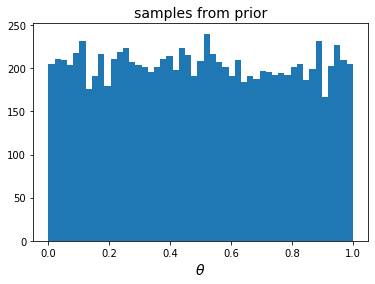

In [19]:
a = 1
b = 1
_ = plt.hist(np.random.beta(a,b, size=10000), 
             bins=np.linspace(0,1,50))
plt.xlabel("$\\theta$", fontsize=14)
plt.title("samples from prior", fontsize=14);

## Building a model with `pystan`

* define a model in Stan's syntax as a string
* compile with `pystan` into a model object
* run inference on a dictionary of data (in this case, coin flips) by calling `model.fit()`
* pull samples from the `fit` object using `fit.extract()["theta"]`; these are samples from the posterior $P(\theta|data)$.

### Define the model

Prior:

$\theta \sim beta(a,b)$

Likelihood:

$y \sim Bernoulli(\theta)$

In [5]:
model_code = """
data {
    int<lower=0> N;
    int<lower=0,upper=1> y[N];
}
parameters {
    real<lower=0,upper=1> theta;
}
model {
    theta ~ beta(1, 1); // SPECIFY YOUR PRIOR HYPERPARAMETERS HERE
    for (n in 1:N)
        y[n] ~ bernoulli(theta);
}
"""

Now compile this into a model. It may take a minute or two:

In [6]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a8c4a9bc1c4fc87293413fceedc8fa9d NOW.


### Data

For this thought experiment we'll just make up data. The data gets stored in a dictionary with an entry for each variable:

* `N` the number of samples
* `y` a list of sample values, each 0 or 1.

Different cases to try:
```
data = {"N":1, "y":[0]} # 1 sample, tails
data = {"N":10, "y":[0,1,0,1,0,1,0,1,0,1]} # 5 heads 5 tails
data = {"N":5, "y":[1,1,1,1,1]} # 5 heads in a row
```

In [10]:
data = {"N":1, "y":[0]}

### Sampling

Remember that our goal in Bayesian inference is to compute a posterior distribution

$P(\theta|x) = \frac{P(x|\theta)P(\theta)}{P(x)}$

For a Beta-Bernoulli model we could compute this directly- but for more interesting models the $P(x)$ will be hard (impossible) to solve. So instead we'll use a technique called **Markov chain Monte Carlo** to samples from $P(\theta|x)$ without computing it directly; we can use these samples to estimate whatever values we need to compute.

In [13]:
fit = model.sampling(data=data, iter=10000, chains=4)

Calling `fit.extract()["theta"]` will give an array of samples; since this is a one-dimensional problem we can just visualize it with a histogram:

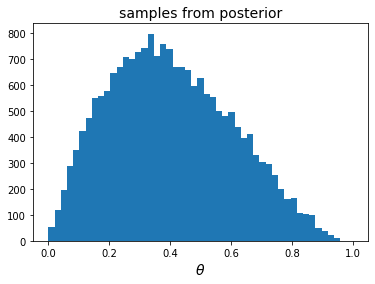

In [21]:
samples = fit.extract()["theta"]
_ = plt.hist(samples, bins=np.linspace(0,1,50))
plt.xlabel("$\\theta$", fontsize=14)
plt.title("samples from posterior", fontsize=14);